In [8]:
import numpy as np
import matplotlib.pyplot as plt

from lab2_proto import*
from lab2_tools import*

from prondict import *

In [9]:
data = np.load('lab2_data.npz', allow_pickle=True)['data']

In [10]:
phoneHMMs_one = np.load('lab2_models_onespkr.npz', allow_pickle=True)['phoneHMMs'].item()
phoneHMMs_all = np.load('lab2_models_all.npz', allow_pickle=True)['phoneHMMs'].item()

In [11]:
isolated = {}
for digit in prondict.keys():
    isolated[digit] = ['sil'] + prondict[digit] + ['sil']

In [12]:
wordHMMs = {}
wordHMMs['o'] = concatHMMs(phoneHMMs_one, isolated['o'])

In [14]:
example = np.load('lab2_example.npz', allow_pickle=True)['example'].item()
list(example.keys())

['filename',
 'samplingrate',
 'gender',
 'speaker',
 'digit',
 'repetition',
 'samples',
 'lmfcc',
 'obsloglik',
 'logalpha',
 'loglik',
 'vloglik',
 'vpath',
 'logbeta',
 'loggamma']

Text(0.5, 1.0, 'HMM log-likelihood of each observation given the state')

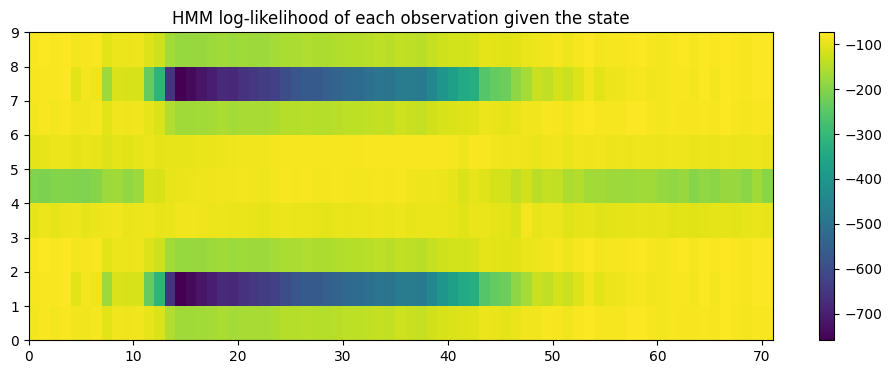

In [22]:
obsloglik = log_multivariate_normal_density_diag(example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])
plt.figure(figsize=(12, 4))
plt.pcolormesh(obsloglik.T)
plt.colorbar()
plt.title("HMM log-likelihood of each observation given the state")

In [ ]:
# Plot the log likelihood for Gaussians from HMMs models corresponding to the same digit on a test utterance


